In [ ]:
# Задача 4.1.
# Используя стандартные средства opencv сохраните изображения сгенерированного набора данных в форматах .png, .jpg, .bmp.
# Выполните чтение сохраненных данных из файла.
# При помощи метрик SSIM, MSE сравните данные.
# Задача 4.2.1.
# Реализуйте алгоритмы downsampling:
#  - max
#  - среднее на выбор ( не average)
# Задача 4.2.2.
# Реализуйте алгоритм Ланцоша для восстановления разрешения исходного изображения.
# При помощи метрик SSIM, MSE сравните исходное изображение и восстановленное в исходном разрешении.

Сравнение с оригиналом:
PNG:
  MSE: 0.0
  SSIM: 1.0000

JPG:
  MSE: 1.3
  SSIM: 0.9886

BMP:
  MSE: 0.0
  SSIM: 1.0000

Сравнение методов даунсэмплинга:
Max Pooling + Ланцош:
  MSE: 4.0
  SSIM: 0.9861
Median Pooling + Ланцош:
  MSE: 1.3
  SSIM: 0.9912


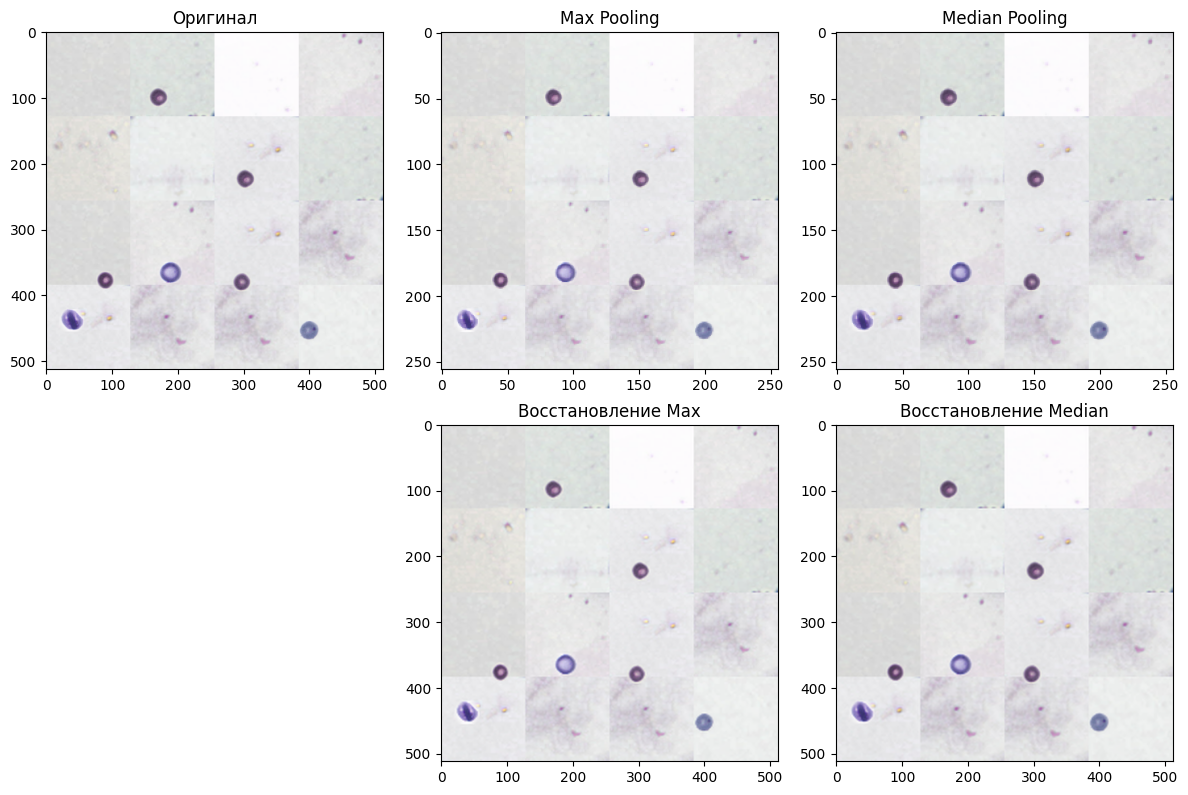

In [3]:
import cv2
import numpy as np
import os
import glob
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


dataset_folder = "generated_images"
save_folder = "converted_images"
os.makedirs(save_folder, exist_ok=True)

def load_images(folder):
    images = []
    for path in glob.glob(f"{folder}/*"):
        img = cv2.imread(path)
        if img is not None:
            images.append((os.path.basename(path), img))
    return images

def convert_images(images, save_dir):
    base_name = os.path.splitext(images[0][0])[0]
    original = images[0][1]
    formats = ['png', 'jpg', 'bmp']
    
    for fmt in formats:
        cv2.imwrite(f"{save_dir}/{base_name}.{fmt}", original)
    return base_name, original

def calculate_mse(orig, img):
    return np.mean((orig - img) ** 2)

def calculate_ssim(orig, img):
    return ssim(orig, img, multichannel=True, channel_axis=2)

def max_pooling(img, factor=2):
    h, w = img.shape[:2]
    new_h, new_w = h // factor, w // factor
    pooled = np.zeros((new_h, new_w, 3), dtype=np.uint8)
    
    for i in range(new_h):
        for j in range(new_w):
            y = i * factor
            x = j * factor
            region = img[y:y+factor, x:x+factor]
            pooled[i,j] = np.max(region, axis=(0,1))
    
    return pooled

def median_pooling(img, factor=2):
    h, w = img.shape[:2]
    new_h, new_w = h // factor, w // factor
    pooled = np.zeros((new_h, new_w, 3), dtype=np.uint8)
    
    for i in range(new_h):
        for j in range(new_w):
            y = i * factor
            x = j * factor
            region = img[y:y+factor, x:x+factor]
            pooled[i,j] = np.median(region, axis=(0,1)).astype(np.uint8)
    
    return pooled

def lanczos_upscale(img, scale=2):
    return cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_LANCZOS4)


images = load_images(dataset_folder)
if not images:
    raise FileNotFoundError("Изображения не найдены")

base_name, original = convert_images(images, save_folder)

converted = {fmt: cv2.imread(f"{save_folder}/{base_name}.{fmt}") for fmt in ['png', 'jpg', 'bmp']}

print("Сравнение с оригиналом:")
for fmt, img in converted.items():
    print(f"{fmt.upper()}:\n  MSE: {calculate_mse(original, img):.1f}\n  SSIM: {calculate_ssim(original, img):.4f}\n")

factor = 2
down_max = max_pooling(original, factor)
down_median = median_pooling(original, factor)

up_max = lanczos_upscale(down_max, factor)
up_median = lanczos_upscale(down_median, factor)

print("Сравнение методов даунсэмплинга:")
print(f"Max Pooling + Ланцош:\n  MSE: {calculate_mse(original, up_max):.1f}\n  SSIM: {calculate_ssim(original, up_max):.4f}")
print(f"Median Pooling + Ланцош:\n  MSE: {calculate_mse(original, up_median):.1f}\n  SSIM: {calculate_ssim(original, up_median):.4f}")

plt.figure(figsize=(12, 8))

plt.subplot(231).set_title('Оригинал')
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))

plt.subplot(232).set_title('Max Pooling')
plt.imshow(cv2.cvtColor(down_max, cv2.COLOR_BGR2RGB))

plt.subplot(233).set_title('Median Pooling')
plt.imshow(cv2.cvtColor(down_median, cv2.COLOR_BGR2RGB))

plt.subplot(235).set_title('Восстановление Max')
plt.imshow(cv2.cvtColor(up_max, cv2.COLOR_BGR2RGB))

plt.subplot(236).set_title('Восстановление Median')
plt.imshow(cv2.cvtColor(up_median, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()